# Simulations with large ptychographic scan steps (ie sparse scans) and with low values for the scattering amplitudes (ie weak).

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation, Simulation
from skimage.feature import register_translation
from skimage.restoration import unwrap_phase
from scipy import io
import copy
import os

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
base_path = os.environ['HOME']

In [6]:
base_path

'/home/skandel'

In [7]:
probe_2d = io.loadmat(f'{base_path}/code/mbptycho/experiments/matlab/datasets/recon_probe_29902.mat')["prb"]
probes_3d_path = f'{base_path}/code/mbptycho/experiments/matlab/datasets/probes_5_peaks.mat'

In [8]:
probe_rescaled = probe_2d / np.abs(probe_2d).max()
probe_trimmed = probe_rescaled.copy()
probe_2d[np.abs(probe_trimmed) < 0.02] = 0
np.sum(np.abs(probe_2d)**2), np.max(np.abs(probe_2d)**2)

(10405784.458692044, 523435.2684263936)

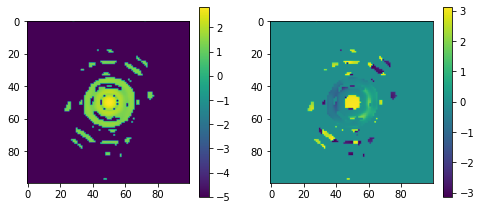

In [9]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d) + 1e-5))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d))
plt.colorbar()
plt.show()

In [10]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

save_plots = False

In [11]:
!ls $sample_data_path

/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks/sample_point_inclusion.pkl


In [12]:
!mkdir $data_path

mkdir: cannot create directory ‘/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks’: File exists


In [13]:
create_new_sample = False
if create_new_sample:
    reload_sample_only_filename = None
    save_sample_only_filename = sample_data_path
else:
    reload_sample_only_filename = sample_data_path
    save_sample_only_filename = sample_data_path

In [14]:
# The "magnitudes_scaling_per_peak" parameter sets the scattering amplitude per peak.

sm = reloadSimulation(sim_data_path, reload_sim=False,
                      reload_sample_only_filename=reload_sample_only_filename,
                      save_sample_only_filename=save_sample_only_filename,
                      new_sim_params={'poisson_noise':True, 
                                      'probes_matlab_file':probes_3d_path, 
                                      'n_scan_positions':9,
                                      'npix_scan_shift':6,
                                      'HKL_list':np.array([[1, 0, 0],
                                                           [1, 1, 0],
                                                           [1, 2, 0],
                                                           [2, 1, 0]]),
                                     'magnitudes_scaling_per_peak': [0.004, 0.0035, 0.0021, 0.001],
                                     'poisson_noise': True},
                      new_extra_sample_params={'strain_type':strain_type, 
                                               'npix_pad_x':5,
                                               'npix_pad_y':5})
sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

Creating new simulation...
Reloading sample from provided file... /home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks/sample_point_inclusion.pkl
Sample reloaded.
Magnitude scaling per peak is supplied. Does not apply random scaling.
Loading probe from matlab data...
Loading successful...
Truncated probe shape (92, 166, 20)
Adding poisson noise...
Truncated probe shape (92, 178, 20)
Adding poisson noise...
Truncated probe shape (92, 200, 20)
Adding poisson noise...
Truncated probe shape (92, 186, 20)
Adding poisson noise...
Saving new simulation...


((200, 200, 20), 0.005841818181818182)

In [15]:
for i in range(3):
    diffs = sm.simulations_per_peak[i].diffraction_patterns
    print(diffs.max(), diffs.sum(axis=(1,2)).max())

71 5415
72 3868
41 1518


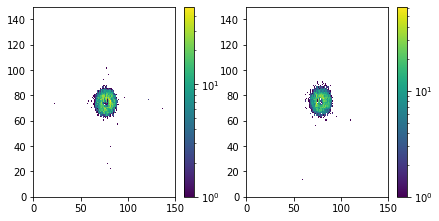

2516
[(71, 5415), (72, 3868), (41, 1518)]
(81, 150, 150)


In [16]:
fig = plt.figure(figsize=[7,3.5])
plt.subplot(1,2,1)

data_out = np.fft.fftshift(sm.simulations_per_peak[0].diffraction_patterns[0])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.subplot(1,2,2)

data_out = np.fft.fftshift(sm.simulations_per_peak[0].diffraction_patterns[15])
data_out[data_out < 1.] = 0
plt.pcolormesh(data_out,
               norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()
print(np.abs(sm.simulations_per_peak[0].diffraction_patterns[0] - 
             sm.simulations_per_peak[0].diffraction_patterns[30]).sum())

print([(sm.simulations_per_peak[i].diffraction_patterns.max(),
        sm.simulations_per_peak[i].diffraction_patterns.sum(axis=(1,2)).max())
       for i in range(3)])
print(sm.simulations_per_peak[0].diffraction_patterns.shape)

In [113]:
ux = sm.sample.Ux_trunc #/ sm.sample.params.lattice[1]
uy = sm.sample.Uy_trunc #/ sm.sample.params.lattice[1]
uz = sm.sample.Uz_trunc #/ sm.sample.params.lattice[1]
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
duz = np.gradient(uz)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy, duz], axis=0)

In [114]:
plots_3d_mask_trunc = (~sm.sample.obj_mask_trunc) | (~sm.sample.magnitudes_trunc_mask)

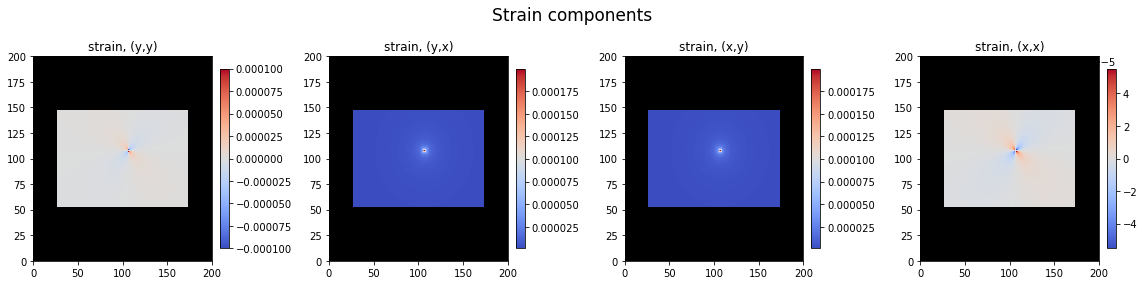

In [115]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j])
        s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        if i < 2 and j < 2:
            sl = s[i,j, :, :, 10]
            
        elif i < 2 and j ==2 :
            sl = s[i, j, :,:,10]
        else:
            sl = s[i, j, :, :,10]
        
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap)
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

if save_plots:
    plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

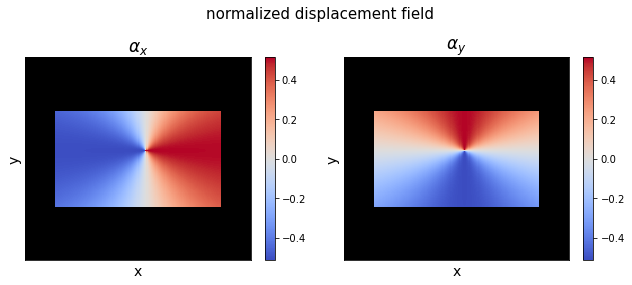

In [116]:
plt.figure(figsize=[9,4])

plt.subplot(1,2,1)
front = sm.sample.Ux_trunc / sm.sample.params.lattice[1]
front[plots_3d_mask_trunc] = np.nan
plt.pcolormesh(front[...,11], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-2, -1, 0, 1, 2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_x$', fontsize=17)

plt.subplot(1,2,2)
front = sm.sample.Uy_trunc / sm.sample.params.lattice[1]
front[plots_3d_mask_trunc] = np.nan
#cmap = mpl.cm.get_cmap('coolwarm')
#cmap.set_bad('black')
plt.pcolormesh(front[...,11], cmap=cmap)
plt.colorbar()
#cbar = plt.colorbar(ticks=[-0.2, -0.1, 0, 0.1, 0.2])
#cbar.ax.tick_params(labelsize=14)
#cbar.ax.set_ylabel(r'$\alpha_y$', fontsize=17) 
plt.xticks([])
plt.yticks([])
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.title(r'$\alpha_y$', fontsize=17)
plt.suptitle("normalized displacement field", fontsize=15)
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/displacement.pdf', bbox_inches='tight')
plt.show()

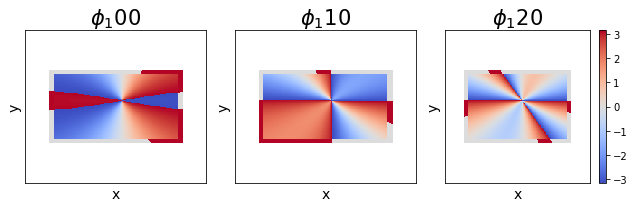

In [117]:
fig, axs = plt.subplots(1, 3, figsize=[9,3])

for i in range(3):
    front = np.angle(sm.sample.rhos[i])
    front[plots_3d_mask_trunc] = np.nan
    cax= axs[i].pcolormesh(front[...,11], cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
    peak = ''.join(sm.params.HKL_list[i].astype('str'))
    axs[i].set_xlabel('x', fontsize=14)
    axs[i].set_ylabel('y', fontsize=14)
    axs[i].set_title(fr"$\phi_{peak}$", fontsize=21)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.colorbar(cax, ax=axs[2])
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/phases.pdf', bbox_inches='tight')
plt.show()

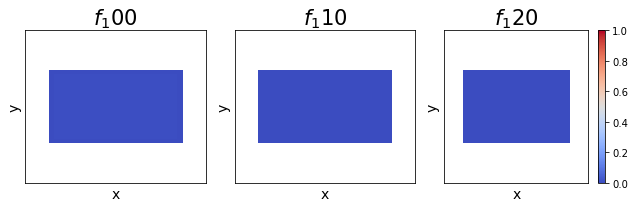

In [118]:
fig, axs = plt.subplots(1, 3, figsize=[9,3])

for i in range(3):
    front = np.abs(sm.rhos[i])
    front[plots_3d_mask_trunc] = np.nan
    cax= axs[i].pcolormesh(front[...,11], cmap='coolwarm', vmin=0, vmax=1.0)
    peak = ''.join(sm.params.HKL_list[i].astype('str'))
    axs[i].set_xlabel('x', fontsize=14)
    axs[i].set_ylabel('y', fontsize=14)
    axs[i].set_title(fr"$f_{peak}$", fontsize=21)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.colorbar(cax, ax=axs[2])
plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}/magnitudes.png', bbox_inches='tight')
plt.show()

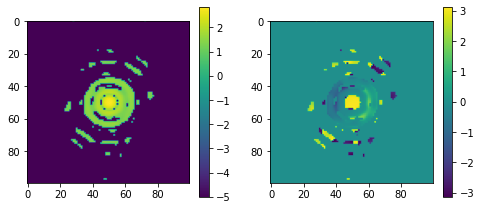

In [8]:
plt.figure(figsize=[8,3.5])
plt.subplot(121)
plt.imshow(np.log10(np.abs(probe_2d) + 1e-5))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(probe_2d))
plt.colorbar()
plt.show()

In [13]:

from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

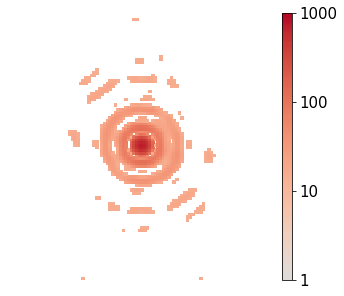

In [39]:
fig, ax = plt.subplots(1,1, figsize=[4, 4], constrained_layout=True)
    

probe_absvals = np.abs(probe_2d)
probe_angvals = np.angle(probe_2d)

#probe_absvals[probe_absvals<1] = 1

new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1)

#plt.sca(axes[0,0])
im = ax.pcolormesh(probe_absvals, cmap=new_cmap, norm=LogNorm(vmin=1, vmax=1000))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[1, 10, 100, 1000])
cb.ax.set_yticklabels([1, 10, 100, 1000])
cb.ax.minorticks_off()
cb.ax.tick_params(labelsize=15)

ax.set_aspect('equal')
ax.set_axis_off()
#ax.text(0.05, 1.02, '(' + string.ascii_lowercase[i] + ') ' + list(subplot_titles.values())[i],
#            transform=ax.transAxes, size=16)
plt.savefig('probe_mag.pdf', bbox_inches='tight')

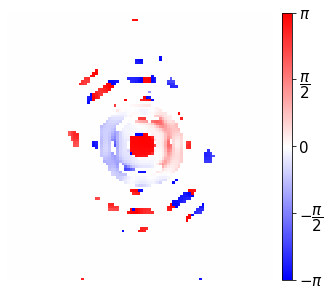

In [46]:
fig, ax = plt.subplots(1,1, figsize=[4, 4], constrained_layout=True)

#probe_angvals[probe_absvals<1] = 0

im = ax.pcolormesh(probe_angvals, cmap='bwr',vmin=-np.pi, vmax=np.pi)
                          # norm=MidpointNormalize(vmin=-np.pi, vmax=np.pi, midpoint=0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.1)
cb = plt.colorbar(im, cax=cax, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cb.ax.minorticks_off()
cb.ax.set_yticklabels([r'$-\pi$', r'$-\dfrac{\pi}{2}$', r'0',  r'$\dfrac{\pi}{2}$', r'$\pi$'])
cb.ax.tick_params(labelsize=15)

ax.set_axis_off()
ax.set_aspect('equal')

plt.savefig('probe_phase.pdf', bbox_inches='tight')

In [22]:
probe_absvals.min()

0.0